# HW2 Path Planning and Collision Checking
Ting-Wei Hsu (twhsu3)

In [51]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Collision checking
import coal

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm
from qpsolvers import solve_qp

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm

# Other utilities
import itertools

import random

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

## Universal Robots UR10
The Universal Robots UR10 is a 6-joint collaborative robot arm.

Load a robot model.

In [52]:
# Load model
robot = load_robot_description(
    'ur10_description',           # name of robot model
    root_joint=None,                # fixed base
)

Add and show all possible collision pairs. Since the robot model has no obstacles yet, these pairs are only associated with self-collision.

In [53]:
robot.collision_model.addAllCollisionPairs()

for i, pair in enumerate(robot.collision_model.collisionPairs):
    print(f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})')

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

 0 :  0 x  1 (base_link_0 x shoulder_link_0)
 1 :  0 x  2 (base_link_0 x upper_arm_link_0)
 2 :  0 x  3 (base_link_0 x forearm_link_0)
 3 :  0 x  4 (base_link_0 x wrist_1_link_0)
 4 :  0 x  5 (base_link_0 x wrist_2_link_0)
 5 :  0 x  6 (base_link_0 x wrist_3_link_0)
 6 :  0 x  7 (base_link_0 x ee_link_0)
 7 :  1 x  2 (shoulder_link_0 x upper_arm_link_0)
 8 :  1 x  3 (shoulder_link_0 x forearm_link_0)
 9 :  1 x  4 (shoulder_link_0 x wrist_1_link_0)
10 :  1 x  5 (shoulder_link_0 x wrist_2_link_0)
11 :  1 x  6 (shoulder_link_0 x wrist_3_link_0)
12 :  1 x  7 (shoulder_link_0 x ee_link_0)
13 :  2 x  3 (upper_arm_link_0 x forearm_link_0)
14 :  2 x  4 (upper_arm_link_0 x wrist_1_link_0)
15 :  2 x  5 (upper_arm_link_0 x wrist_2_link_0)
16 :  2 x  6 (upper_arm_link_0 x wrist_3_link_0)
17 :  2 x  7 (upper_arm_link_0 x ee_link_0)
18 :  3 x  4 (forearm_link_0 x wrist_1_link_0)
19 :  3 x  5 (forearm_link_0 x wrist_2_link_0)
20 :  3 x  6 (forearm_link_0 x wrist_3_link_0)
21 :  3 x  7 (forearm_link_0

Put the robot at its neutral configuration and check for collisions.

In [54]:
# Get the neutral configuration
q = pin.neutral(robot.model)

# Update geometry placements at this configuration
pin.updateGeometryPlacements(
    robot.model,
    robot.data,
    robot.collision_model,
    robot.collision_data,
    q,
)

# Find all collisions
in_collision = pin.computeCollisions(robot.collision_model, robot.collision_data, False)

# Show all pairs in collision
for i, pair in enumerate(robot.collision_model.collisionPairs):
    s = f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})'
    if robot.collision_data.collisionResults[i].isCollision():
        print(f'{s} : COLLISION')
    else:
        print(s)

 0 :  0 x  1 (base_link_0 x shoulder_link_0)
 1 :  0 x  2 (base_link_0 x upper_arm_link_0)
 2 :  0 x  3 (base_link_0 x forearm_link_0)
 3 :  0 x  4 (base_link_0 x wrist_1_link_0)
 4 :  0 x  5 (base_link_0 x wrist_2_link_0)
 5 :  0 x  6 (base_link_0 x wrist_3_link_0)
 6 :  0 x  7 (base_link_0 x ee_link_0)
 7 :  1 x  2 (shoulder_link_0 x upper_arm_link_0) : COLLISION
 8 :  1 x  3 (shoulder_link_0 x forearm_link_0)
 9 :  1 x  4 (shoulder_link_0 x wrist_1_link_0)
10 :  1 x  5 (shoulder_link_0 x wrist_2_link_0)
11 :  1 x  6 (shoulder_link_0 x wrist_3_link_0)
12 :  1 x  7 (shoulder_link_0 x ee_link_0)
13 :  2 x  3 (upper_arm_link_0 x forearm_link_0) : COLLISION
14 :  2 x  4 (upper_arm_link_0 x wrist_1_link_0)
15 :  2 x  5 (upper_arm_link_0 x wrist_2_link_0)
16 :  2 x  6 (upper_arm_link_0 x wrist_3_link_0)
17 :  2 x  7 (upper_arm_link_0 x ee_link_0)
18 :  3 x  4 (forearm_link_0 x wrist_1_link_0) : COLLISION
19 :  3 x  5 (forearm_link_0 x wrist_2_link_0)
20 :  3 x  6 (forearm_link_0 x wrist_3_

Create a hard-coded list of all pairs that are in collision at the neutral configuration (this could be automated). Then, remove these pairs from the list to check.

In [55]:
# Create a list of useless collision pairs (i.e., those pairs that are always
# in collision even at the neutral configuration)
useless_pairs = [7, 13, 18, 22, 25]

# Remove useless collision pairs - it is important that you remove these from
# last to first (i.e., from high to low index) because higher indices will change
# as you remove lower ones
for i in sorted(useless_pairs, reverse=True):
    robot.collision_model.removeCollisionPair(robot.collision_model.collisionPairs[i])

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Check for collisions again at the neutral configuration to make sure we did this correctly.
# Get the neutral configuration
q = pin.neutral(robot.model)

# Update geometry placements at this configuration
pin.updateGeometryPlacements(
    robot.model,
    robot.data,
    robot.collision_model,
    robot.collision_data,
    q,
)

# Find all collisions
in_collision = pin.computeCollisions(robot.collision_model, robot.collision_data, False)

# Show all pairs in collision
for i, pair in enumerate(robot.collision_model.collisionPairs):
    s = f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})'
    if robot.collision_data.collisionResults[i].isCollision():
        print(f'{s} : COLLISION')
    else:
        print(s)

 0 :  0 x  1 (base_link_0 x shoulder_link_0)
 1 :  0 x  2 (base_link_0 x upper_arm_link_0)
 2 :  0 x  3 (base_link_0 x forearm_link_0)
 3 :  0 x  4 (base_link_0 x wrist_1_link_0)
 4 :  0 x  5 (base_link_0 x wrist_2_link_0)
 5 :  0 x  6 (base_link_0 x wrist_3_link_0)
 6 :  0 x  7 (base_link_0 x ee_link_0)
 7 :  1 x  3 (shoulder_link_0 x forearm_link_0)
 8 :  1 x  4 (shoulder_link_0 x wrist_1_link_0)
 9 :  1 x  5 (shoulder_link_0 x wrist_2_link_0)
10 :  1 x  6 (shoulder_link_0 x wrist_3_link_0)
11 :  1 x  7 (shoulder_link_0 x ee_link_0)
12 :  2 x  4 (upper_arm_link_0 x wrist_1_link_0)
13 :  2 x  5 (upper_arm_link_0 x wrist_2_link_0)
14 :  2 x  6 (upper_arm_link_0 x wrist_3_link_0)
15 :  2 x  7 (upper_arm_link_0 x ee_link_0)
16 :  3 x  5 (forearm_link_0 x wrist_2_link_0)
17 :  3 x  6 (forearm_link_0 x wrist_3_link_0)
18 :  3 x  7 (forearm_link_0 x ee_link_0)
19 :  4 x  6 (wrist_1_link_0 x wrist_3_link_0)
20 :  4 x  7 (wrist_1_link_0 x ee_link_0)
21 :  5 x  7 (wrist_2_link_0 x ee_link_0)


## Define functions to construct obstacles and convert collision geometries to convex meshes


In [56]:
def XYZYPRtoSE3(xyzypr):
    """specify the pose of the obstacle by x, y, z coordinates and body-fixed yaw, pitch, and roll angles"""
    R = pin.utils.rotate('z', xyzypr[3]) @ pin.utils.rotate('y', xyzypr[4]) @ pin.utils.rotate('x', xyzypr[5])
    p = np.array(xyzypr[:3])
    return pin.SE3(R, p)

In [57]:
def primitive_to_convex(shape, n=32):
    """
    Convert a coal primitive shape to a ConvexBase by sampling
    its surface, building a BVHModel from the points, and computing
    the convex hull.
    """
    if isinstance(shape, coal.Box):
        # half-extents
        x, y, z = shape.halfSide
        verts = np.array([
            [ x,  y,  z], [ x,  y, -z], [ x, -y,  z], [ x, -y, -z],
            [-x,  y,  z], [-x,  y, -z], [-x, -y,  z], [-x, -y, -z],
        ])

    elif isinstance(shape, coal.Cylinder):
        r = shape.radius
        h = shape.halfLength
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        circle = np.column_stack([r * np.cos(theta), r * np.sin(theta)])
        top = np.column_stack([circle, np.full(n, h)])
        bot = np.column_stack([circle, np.full(n, -h)])
        verts = np.vstack([top, bot])

    elif isinstance(shape, coal.Cone):
        r = shape.radius
        h = shape.halfLength
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        base = np.column_stack([r * np.cos(theta), r * np.sin(theta),
                                np.full(n, -h)])
        apex = np.array([[0.0, 0.0, h]])
        verts = np.vstack([base, apex])

    elif isinstance(shape, coal.Sphere):
        verts = _sphere_points(shape.radius, n)

    elif isinstance(shape, coal.Ellipsoid):
        rx, ry, rz = shape.radii
        unit = _sphere_points(1.0, n)
        verts = unit * np.array([rx, ry, rz])

    elif isinstance(shape, coal.Capsule):
        r = shape.radius
        h = shape.halfLength
        # hemisphere + cylinder ring
        unit = _sphere_points(1.0, n)
        top_hemi = unit[unit[:, 2] >= 0] * r + [0, 0, h]
        bot_hemi = unit[unit[:, 2] <= 0] * r + [0, 0, -h]
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        ring = np.column_stack([r * np.cos(theta), r * np.sin(theta),
                                np.zeros(n)])
        verts = np.vstack([top_hemi, bot_hemi,
                           ring + [0, 0, h], ring + [0, 0, -h]])

    else:
        raise TypeError(f"Unsupported shape type: {type(shape)}")

    return _points_to_convex(verts)


def _sphere_points(radius, n):
    """Fibonacci sphere sampling."""
    indices = np.arange(n * n // 2)  # enough points
    # Use a simpler grid approach
    u = np.linspace(0, 2 * np.pi, n, endpoint=False)
    v = np.linspace(0, np.pi, n // 2 + 1)
    theta, phi = np.meshgrid(u, v)
    theta, phi = theta.ravel(), phi.ravel()
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return np.column_stack([x, y, z])


def _points_to_convex(points):
    """Build a BVHModel from a point cloud and compute its convex hull."""
    bvh = coal.BVHModelOBBRSS()
    bvh.beginModel(0, len(points))
    bvh.addVertices(points)
    bvh.endModel()
    bvh.buildConvexHull(True, "Qt")
    return bvh.convex

## Define functions to check for collision

In [58]:
def boolean_collision(q):
    pin.updateGeometryPlacements(
        robot.model,
        robot.data,
        robot.collision_model,
        robot.collision_data,
        q)
    return pin.computeCollisions(robot.collision_model, robot.collision_data, False)

def distance_collision(q):
    if boolean_collision(q):
        return 0.
    else:
        # Compute the distance between each collision pair and
        # get the index of the pair with the smallest distance
        i = pin.computeDistances(robot.collision_model, robot.collision_data)
        # Return that smallest distance
        return robot.collision_data.distanceResults[i].min_distance

## The RRT-Connect algorithm (our implementation)

Define a simple tree data structure.

In [59]:
class Node:
    def __init__(self, q, parent=None):
        self.q = q
        self.parent = parent
        self.children = []
        if parent is not None:
            parent.children.append(self)
    
    def __iter__(self):
        yield self
        for child in self.children:
            yield from child

In [60]:
def find_closest_node_in_tree(tree, q):
    """
    Returns the node in the tree whose configuration is closest to q.
    """
    closest_node = None
    dist_min = float('inf')
    for node in tree:
        d = np.linalg.norm(node.q - q)
        if d < dist_min:
            dist_min = d
            closest_node = node
    return closest_node

def boolean_collision_edge(q1, q2, res=1e-3):
    """
    Returns True if the straight-line path from q1 to q2 has a collision
    (checked at resolution 1e-3) and False otherwise.
    """
    dist = np.linalg.norm(q1-q2)
    T = round(dist/res)
    for t in range(T):
        q = q1 + (q2 - q1) / dist * res * t
        if boolean_collision(q):
            return True
    return False

def extend(tree, q, epsilon = 0.1):
    node_closest = find_closest_node_in_tree(tree, q)
    v = q - node_closest.q
    v_norm = np.linalg.norm(v)
    if v_norm <= epsilon:
        q_new = q
        scenario = 1 # reached
    else:
        q_new = node_closest.q + v / v_norm * epsilon
        scenario = 2 # advanced
    if not boolean_collision_edge(q_new, node_closest.q):
        node_new = Node(q_new, parent = node_closest) # the tree is updated
    else:
        node_new = None
        scenario = 3 # trapped (collision)
    return scenario, node_new

def connect(tree, q):
    while True:
        scenario, node_new = extend(tree, q)
        if scenario == 1 or scenario == 3:
            break
    return scenario, node_new # can only be 'reached' or 'trapped'
    
def plan_path(q_start, q_goal, max_iters=1000):
    """
    Returns a path - a 2d numpy array with a waypoint in each row - from
    q_start to q_goal, or None if no path is found before the maximum number
    of iterations has been reached.
    """

    # Create trees rooted at start and goal
    tree_a = Node(q_start)
    tree_b = Node(q_goal)

    # Iterate for at most max_iters iterations
    for iter in range(max_iters):
        # Sample a random configuration that satisfies joint limits, keeping
        # it only if not in collision
        while True:
            q_rand = pin.randomConfiguration(robot.model)
            if not boolean_collision(q_rand):
                break

        scenario_a, node_new_a = extend(tree_a, q_rand)
        if scenario_a != 3 and node_new_a is not None:
            scenario_b, node_new_b = connect(tree_b, node_new_a.q)
            if scenario_b == 1:
                # If the configuration was connected to both forward and backward trees,
                # then a solution has been found - return it as a list of waypoints                
                path_a = []
                node = node_new_a
                while True:
                    path_a.append(node.q)
                    if node.parent is None:
                        break
                    node = node.parent
                
                path_b = []
                node = node_new_b
                while True:
                    path_b.append(node.q)
                    if node.parent is None:
                        break
                    node = node.parent
                
                if np.all(path_a[-1] == q_start):
                    path_a = path_a[::-1]
                    path = path_a + path_b
                elif np.all(path_b[-1] == q_start):
                    path_b = path_b[::-1]
                    path = path_b + path_a
                return path

        # Swap tree_a and tree_b     
        tree_a, tree_b = tree_b, tree_a
    
    # Declare failure if no path was found
    print('FAILURE (after {max_iters} iterations)')
    return None

## Interpolation and Smoothing functions

Define a function to interpolate the path.

In [61]:
def interpolate_path(path, res=5e-2):
    """
    Adds intermediate waypoints so that the distance between each consecutive
    waypoint is at most res. Should return a *copy* of the path with the result
    - should not modify the path in place.
    """
    path_interp = [path[0]]
    
    for i in range(len(path) - 1):
        q1 = path[i]
        q2 = path[i + 1]
        dist = np.linalg.norm(q2 - q1)
        if dist > res:
            for t in range(int(np.ceil(dist / res))):
                q_interp = q1 + t * (q2 - q1) / dist * res
                path_interp.append(q_interp)
    
    return path_interp

Define a function to smooth the path.

In [62]:
def get_path_lengths(path):
    """
    Returns a 1d array with the same length as path and with the
    cumulative sum of path lengths in each entry.

    Suppose path has waypoints q1, ..., qn. Then, the array that
    is returned should be as follows:

    [
        0.,
        distance from q1 to q2,
        (distance from q1 to q2) + (distance from q2 to q3),
        ...
    ]
    """
    path_lengths = [0]
    dist_cumsum = 0
    for i in range(len(path)-1):
        q1 = path[i]
        q2 = path[i + 1]
        dist_cumsum += np.linalg.norm(q2 - q1)
        path_lengths.append(dist_cumsum)

    return path_lengths

def smooth_path(path, max_iters=100):
    """
    Applies shortcutting max_iters times to smooth the path. Should
    return a *copy* of the path with the result - should not modify
    the path in place.
    """
    # Compute path length
    path_lengths = [get_path_lengths(path)[-1].item()]

    smooth_path = path.copy()

    # Iterate max_iters times
    for i in range(max_iters):
        # Sample two points q1 and q2 along the path, keeping them only
        # if they are not on the same edge
        while True:
            ind = random.sample(range(len(smooth_path)), 2)
            if abs(ind[0] - ind[1]) > 1:
                q1 = smooth_path[ind[0]]
                q2 = smooth_path[ind[1]]
                break
        
        # Continue only if the straight-line path between q1 and q2 is collision-free
        if not boolean_collision_edge(q1, q2):
            # Replace all waypoints between q1 and q2 with the new straightline path
            ind1 = min(ind[0], ind[1])
            ind2 = max(ind[0], ind[1])
            smooth_path = smooth_path[0:ind1+1] + smooth_path[ind2:]

        # Recompute path lengths
        path_lengths.append(get_path_lengths(smooth_path)[-1].item())
    
    return smooth_path, path_lengths

## Planning Problem #1 (easy)

Add obstacles and enable checking for collision with them

In [63]:
# Number of collision geometries are associated only with the robot
n_robot_geoms = len(robot.collision_model.geometryObjects)

# Define the pose of each capsule
xyz_ypr = [
    [ 0.4,  0.0, 0.5, 0., 0., np.pi / 2],
    [-0.4, -0.0, 1.0, 0., 0., np.pi / 2],
    [-0.5,  0.0, 0.2, 0., 0., np.pi / 2],
]

# Define the radius and length of each capsule
rad_len = [
    [0.1, 0.4],
    [0.1, 0.4],
    [0.1, 0.4],
]

# Define the color of each capsule (all the same)
rgba = np.array([1.0, 0.2, 0.2, 1.0])

# Add each capsule as an obstacle that is fixed in space
for i, (xyz_ypr_i, rad_len_i) in enumerate(zip(xyz_ypr, rad_len)):
    # Define obstacle
    obs = pin.GeometryObject.CreateCapsule(rad_len_i[0], rad_len_i[1])
    obs.meshColor = rgba
    obs.name = f'obs{i}'
    obs.parentJoint = 0
    obs.placement = XYZYPRtoSE3(xyz_ypr_i)

    # Add obstacle to both the visual model and the collision model
    robot.collision_model.addGeometryObject(obs)
    robot.visual_model.addGeometryObject(obs)

# Add collision pairs for all obstacles
# Iterate over all robot geometries
for i in range(n_robot_geoms):
    # Iterate over all obstacle geometries
    for j in range(n_robot_geoms, len(robot.collision_model.geometryObjects)):
        robot.collision_model.addCollisionPair(pin.CollisionPair(i, j))

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Show all collision pairs again
for i, pair in enumerate(robot.collision_model.collisionPairs):
    print(f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})')

# Convert all collision geometries to convex meshes
# Apply function to all geometry objects in collision_model
for geom_obj in robot.collision_model.geometryObjects:
    geom = geom_obj.geometry
    if isinstance(geom, coal.ShapeBase):
        convex = primitive_to_convex(geom)
        geom_obj.geometry = convex
    elif isinstance(geom, coal.BVHModelBase):
        geom.buildConvexHull(True, 'Qt')
        geom_obj.geometry = geom.convex

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

 0 :  0 x  1 (base_link_0 x shoulder_link_0)
 1 :  0 x  2 (base_link_0 x upper_arm_link_0)
 2 :  0 x  3 (base_link_0 x forearm_link_0)
 3 :  0 x  4 (base_link_0 x wrist_1_link_0)
 4 :  0 x  5 (base_link_0 x wrist_2_link_0)
 5 :  0 x  6 (base_link_0 x wrist_3_link_0)
 6 :  0 x  7 (base_link_0 x ee_link_0)
 7 :  1 x  3 (shoulder_link_0 x forearm_link_0)
 8 :  1 x  4 (shoulder_link_0 x wrist_1_link_0)
 9 :  1 x  5 (shoulder_link_0 x wrist_2_link_0)
10 :  1 x  6 (shoulder_link_0 x wrist_3_link_0)
11 :  1 x  7 (shoulder_link_0 x ee_link_0)
12 :  2 x  4 (upper_arm_link_0 x wrist_1_link_0)
13 :  2 x  5 (upper_arm_link_0 x wrist_2_link_0)
14 :  2 x  6 (upper_arm_link_0 x wrist_3_link_0)
15 :  2 x  7 (upper_arm_link_0 x ee_link_0)
16 :  3 x  5 (forearm_link_0 x wrist_2_link_0)
17 :  3 x  6 (forearm_link_0 x wrist_3_link_0)
18 :  3 x  7 (forearm_link_0 x ee_link_0)
19 :  4 x  6 (wrist_1_link_0 x wrist_3_link_0)
20 :  4 x  7 (wrist_1_link_0 x ee_link_0)
21 :  5 x  7 (wrist_2_link_0 x ee_link_0)
2

Display robot and obstacles in browser.

In [64]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Choose what to display
vis.displayFrames(False)
# Switch from showing "visual" geometry to showing "collision" geometry
vis.displayVisuals(False)
vis.displayCollisions(True)

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Change the camera view
vis.setCameraPosition(np.array([0., 2., 0.75]))
vis.setCameraTarget(np.array([0., 0., 0.75]))

# Set to neutral position
q = pin.neutral(robot.model)
print(f'{q = }')

# Forward kinematics
pin.forwardKinematics(robot.model, robot.data, q)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(q)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/
q = array([0., 0., 0., 0., 0., 0.])


In [15]:
# Callback function that receives all slider values
def on_slider_change(change):
    global q
    q = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)

# Create sliders for each joint
sliders = []
for i in range(robot.nq):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Apply implementation of RRT-Connect to plan a path.

In [65]:
# Define start and goal configurations
q_start = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
q_goal = np.array([np.pi/2, -np.pi/2, 0.0, 0.0, 0.0, 0.0])

# Plan path
path = plan_path(q_start, q_goal, max_iters=1000)
#print(path)

Visualize the original path after interpolation.

In [66]:
# Interpolate original path
path_original = interpolate_path(path)

# Visualize the result (checking for collision to be sure)
for q in path_original:
    vis.display(q)
    if boolean_collision(q):
        raise Exception('collision!')
    time.sleep(0.025)

Smooth the path

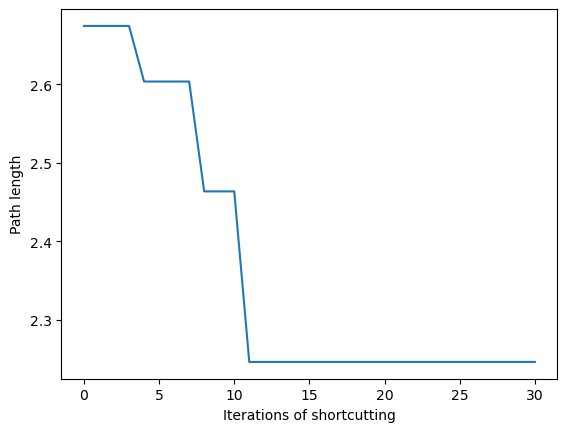

In [69]:
# Smooth original path
path_smoothed, path_length = smooth_path(path, 30)

plt.figure()
plt.plot(path_length)
plt.xlabel('Iterations of shortcutting')
plt.ylabel('Path length')
plt.show()


Visualize the smoothed path after interpolation

In [70]:
# Interpolate smoothed path
path_smoothed = interpolate_path(path_smoothed)

# Visualize the result (checking for collision to be sure)
for q in path_smoothed:
    vis.display(q)
    if boolean_collision(q):
        raise Exception('collision!')
    time.sleep(0.025)

Plot histogram of computation times and print experimental convergence rate

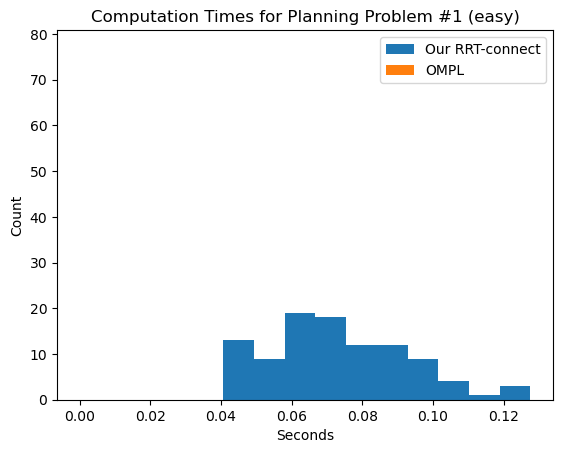

Mean computation times
 Our RRT-connect: 0.073 s
 OMPL: 0.000 s
Experimental convergence rate
 Our RRT-connect: 100.00 %


In [72]:
t_rrt = []
t_ompl = []

fail_rrt = 0
fail_ompl = 0

# Number of iterations
N = 100

# Iterate
for i in range(N):
    start_time = time.perf_counter_ns()
    path = plan_path(q_start, q_goal, max_iters=1000)
    end_time = time.perf_counter_ns()
    t_rrt.append((end_time - start_time)/1e9)
    if path is None:
        fail_rrt += 1

    start_time = time.perf_counter_ns()
    #TODO: OMPL 
    end_time = time.perf_counter_ns()
    t_ompl.append((end_time - start_time)/1e9)

# Show histograms
plt.hist(t_rrt, label='Our RRT-connect')
plt.hist(t_ompl, label='OMPL')
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.title('Computation Times for Planning Problem #1 (easy)')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Our RRT-connect: {np.mean(t_rrt):.3f} sec')
print(f' OMPL: {np.mean(t_ompl):.3f} sec')

# Print experimental convergence rate
print(f'Experimental convergence rate')
print(f' Our RRT-connect: {(N-fail_rrt)/N*100:2.2f} %')
#print(f' OMPL: {:8.0f}%')

## Planning Problem #2 (hard)

Add obstacles and enable checking for collision with them

In [73]:
# Remove previous obstacles named 'obs*' (safer than relying on counts)
obs_to_remove = [go.name for go in robot.collision_model.geometryObjects if go.name.startswith('obs')]

# Remove all collision pairs that reference those obstacles
for pair in list(robot.collision_model.collisionPairs):
    name1 = robot.collision_model.geometryObjects[pair.first].name
    name2 = robot.collision_model.geometryObjects[pair.second].name
    if name1 in obs_to_remove or name2 in obs_to_remove:
        try:
            robot.collision_model.removeCollisionPair(pair)
        except Exception:
            pass

# Remove geometry and visual objects for those obstacles
for name in obs_to_remove:
    try:
        robot.collision_model.removeGeometryObject(name)
    except Exception:
        pass
    try:
        robot.visual_model.removeGeometryObject(name)
    except Exception:
        pass

# Recompute the number of robot-only geometry objects (everything remaining is robot)
n_robot_geoms = len(robot.collision_model.geometryObjects)

# Now add NEW obstacles for Problem 2
xyz_ypr_problem2 = [
    #[0.0, 0.0, -0.5, 0., 0., np.pi / 2],
    [0.0, 1.2, 0.25, 0., np.pi / 2, 0.0],
    [0.0, -0.8, 0.5, 0., np.pi / 2, 0.0],
    #[0.0, -0.8, 1.0, 0., np.pi / 2, 0.0],
    [0.2, -0.1, 0.5, 0., 0., np.pi / 2],
    [-0.4, 0.4, 0.5, 0., 0., np.pi / 2],
    [-0.8, 0.4, 0.4, 0., 0., np.pi / 2],
    [0.1, 0.65, 0.6, 0., 0., np.pi / 2],
    [0.5, 0.0, -0.2, 0., 0., np.pi / 2],
]

rad_len_problem2 = [
    #[0.5, 3.0],
    [0.25, 3.0],
    [0.25, 3.0],
    #[0.15, 3.0],
    [0.2, 0.25],
    [0.1, 0.8],
    [0.1, 0.5],
    [0.1, 0.2],
    [0.1, 1.0],
]

rgba = np.array([1.0, 0.2, 0.2, 1.0])

# Add new obstacles
for i, (xyz_ypr_i, rad_len_i) in enumerate(zip(xyz_ypr_problem2, rad_len_problem2)):
    obs = pin.GeometryObject.CreateCapsule(rad_len_i[0], rad_len_i[1])
    obs.meshColor = rgba
    obs.name = f'obs{i}'
    obs.parentJoint = 0
    obs.placement = XYZYPRtoSE3(xyz_ypr_i)
    robot.collision_model.addGeometryObject(obs)
    robot.visual_model.addGeometryObject(obs)

# Add collision pairs for all obstacles (robot geoms x new obs geoms)
for i in range(n_robot_geoms):
    for j in range(n_robot_geoms, len(robot.collision_model.geometryObjects)):
        robot.collision_model.addCollisionPair(pin.CollisionPair(i, j))

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Show all collision pairs again
#for i, pair in enumerate(robot.collision_model.collisionPairs):
#    print(f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})')

# Convert all collision geometries to convex meshes
for geom_obj in robot.collision_model.geometryObjects:
    geom = geom_obj.geometry
    if isinstance(geom, coal.Convex):
        # Already a convex object, no conversion needed
        pass
    elif isinstance(geom, coal.ShapeBase):
        convex = primitive_to_convex(geom)
        geom_obj.geometry = convex
    elif isinstance(geom, coal.BVHModelBase):
        geom.buildConvexHull(True, 'Qt')
        geom_obj.geometry = geom.convex

# Update robot data after conversion
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Display robot in browser
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Choose what to display
vis.displayFrames(False)
# Switch from showing "visual" geometry to showing "collision" geometry
vis.displayVisuals(False)
vis.displayCollisions(True)

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Change the camera view
vis.setCameraPosition(np.array([0., 2., 0.75]))
vis.setCameraTarget(np.array([0., 0., 0.75]))

# Set to neutral position
q = pin.neutral(robot.model)
print(f'{q = }')

# Forward kinematics
pin.forwardKinematics(robot.model, robot.data, q)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(q)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/
q = array([0., 0., 0., 0., 0., 0.])


In [74]:
# Create sliders for each joint
sliders = []
for i in range(robot.nq):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Implement RRT-connect to plan a path

In [75]:
# Define start and goal configurations
q_start = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
q_goal = np.array([-12.0, -180, 80.0, 0.0, 0.0, 0.0])/180*np.pi

# Plan path
path = plan_path(q_start, q_goal, max_iters=10000)
#print(path)

Visualize the original path after interpolation.

In [76]:
# Interpolate original path
path_original = interpolate_path(path)

# Visualize the result (checking for collision to be sure)
for q in path_original:
    vis.display(q)
    if boolean_collision(q):
        raise Exception('collision!')
    time.sleep(0.025)

Visualize the smoothed path after interpolation.

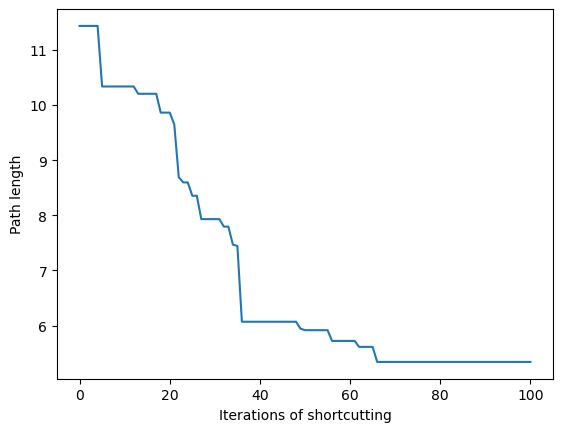

In [78]:
# Smooth original path
path_smoothed, path_length = smooth_path(path, 100)

plt.figure()
plt.plot(path_length)
plt.xlabel('Iterations of shortcutting')
plt.ylabel('Path length')
plt.show()

In [79]:
# Interpolate smoothed path
path_smoothed = interpolate_path(path_smoothed)

# Visualize the result (checking for collision to be sure)
for q in path_smoothed:
    vis.display(q)
    if boolean_collision(q):
        raise Exception('collision!')
    time.sleep(0.025)

Plot histogram of computation times and print experimental convergence rate

FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters} iterations)
FAILURE (after {max_iters

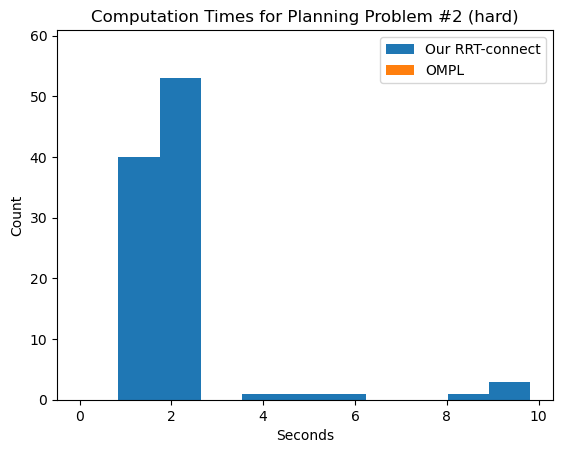

Mean computation times
 Our RRT-connect: 2.140 sec
 OMPL: 0.000 sec
Experimental convergence rate
 Our RRT-connect: 65.00 %


In [80]:
t_rrt = []
t_ompl = []

fail_rrt = 0
fail_ompl = 0

# Number of iterations
N = 100

# Iterate
for i in range(N):
    start_time = time.perf_counter_ns()
    path = plan_path(q_start, q_goal, max_iters=1000)
    end_time = time.perf_counter_ns()
    t_rrt.append((end_time - start_time)/1e9)
    if path is None:
        fail_rrt += 1

    start_time = time.perf_counter_ns()
    #TODO: OMPL 
    end_time = time.perf_counter_ns()
    t_ompl.append((end_time - start_time)/1e9)

# Show histograms
plt.hist(t_rrt, label='Our RRT-connect')
plt.hist(t_ompl, label='OMPL')
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.title('Computation Times for Planning Problem #2 (hard)')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Our RRT-connect: {np.mean(t_rrt):.3f} sec')
print(f' OMPL: {np.mean(t_ompl):.3f} sec')

# Print experimental convergence rate
print(f'Experimental convergence rate')
print(f' Our RRT-connect: {(N-fail_rrt)/N*100:2.2f} %')
#print(f' OMPL: {:8.0f} %')

## Planning Problem #3 (infeasible)

In this problem, we deliberately create enough obstacles such that path planning is guaranteed infeasible.

In [91]:
# Remove previous obstacles named 'obs*' (safer than relying on counts)
obs_to_remove = [go.name for go in robot.collision_model.geometryObjects if go.name.startswith('obs')]

# Remove all collision pairs that reference those obstacles
for pair in list(robot.collision_model.collisionPairs):
    name1 = robot.collision_model.geometryObjects[pair.first].name
    name2 = robot.collision_model.geometryObjects[pair.second].name
    if name1 in obs_to_remove or name2 in obs_to_remove:
        try:
            robot.collision_model.removeCollisionPair(pair)
        except Exception:
            pass

# Remove geometry and visual objects for those obstacles
for name in obs_to_remove:
    try:
        robot.collision_model.removeGeometryObject(name)
    except Exception:
        pass
    try:
        robot.visual_model.removeGeometryObject(name)
    except Exception:
        pass

# Recompute the number of robot-only geometry objects (everything remaining is robot)
n_robot_geoms = len(robot.collision_model.geometryObjects)

# Now add NEW obstacles for Problem 3
xyz_ypr_problem3 = [
    [0.0, 1.2, 0.25, 0., np.pi / 2, 0.0],
    [0.0, -0.8, 0.5, 0., np.pi / 2, 0.0],
    [0.0, -0.5, 0.0, np.pi/2, 0.0, 0.0],
    [0.2, -0.1, 0.5, 0., 0., np.pi / 2],
    [-0.4, 0.4, 0.5, 0., 0., np.pi / 2],
    [-0.8, 0.4, 0.4, 0., 0., np.pi / 2],
    [0.1, 0.65, 0.6, 0., 0., np.pi / 2],
    [0.5, 0.0, -0.2, 0., 0., np.pi / 2],
]

rad_len_problem3 = [
    [0.25, 2.0],
    [0.25, 2.0],
    [0.15, 1.0],
    [0.2, 0.5],
    [0.1, 0.8],
    [0.1, 0.5],
    [0.1, 0.5],
    [0.1, 1.0],
]

rgba = np.array([1.0, 0.2, 0.2, 1.0])

# Add new obstacles
for i, (xyz_ypr_i, rad_len_i) in enumerate(zip(xyz_ypr_problem3, rad_len_problem3)):
    obs = pin.GeometryObject.CreateCapsule(rad_len_i[0], rad_len_i[1])
    obs.meshColor = rgba
    obs.name = f'obs{i}'
    obs.parentJoint = 0
    obs.placement = XYZYPRtoSE3(xyz_ypr_i)
    robot.collision_model.addGeometryObject(obs)
    robot.visual_model.addGeometryObject(obs)

# Add collision pairs for all obstacles (robot geoms x new obs geoms)
for i in range(n_robot_geoms):
    for j in range(n_robot_geoms, len(robot.collision_model.geometryObjects)):
        robot.collision_model.addCollisionPair(pin.CollisionPair(i, j))

# Update robot data
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Show all collision pairs again
for i, pair in enumerate(robot.collision_model.collisionPairs):
    print(f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})')


# Convert all collision geometries to convex meshes
for geom_obj in robot.collision_model.geometryObjects:
    geom = geom_obj.geometry
    if isinstance(geom, coal.Convex):
        # Already a convex object, no conversion needed
        pass
    elif isinstance(geom, coal.ShapeBase):
        convex = primitive_to_convex(geom)
        geom_obj.geometry = convex
    elif isinstance(geom, coal.BVHModelBase):
        geom.buildConvexHull(True, 'Qt')
        geom_obj.geometry = geom.convex

# Update robot data after conversion
robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()

# Display robot in browser
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Choose what to display
vis.displayFrames(False)
# Switch from showing "visual" geometry to showing "collision" geometry
vis.displayVisuals(False)
vis.displayCollisions(True)

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Change the camera view
vis.setCameraPosition(np.array([0., 2., 0.75]))
vis.setCameraTarget(np.array([0., 0., 0.75]))

# Set to neutral position
q = pin.neutral(robot.model)
print(f'{q = }')

# Forward kinematics
pin.forwardKinematics(robot.model, robot.data, q)
pin.updateFramePlacements(robot.model, robot.data)

vis.display(q)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/
q = array([0., 0., 0., 0., 0., 0.])


Implement RRT-connect

In [92]:
# Define start and goal configurations
q_start = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
q_goal = np.array([-12.0, -180, 80.0, 0.0, 0.0, 0.0])/180*np.pi

# Plan path
path = plan_path(q_start, q_goal, max_iters=1000)
#print(path)

FAILURE (after {max_iters} iterations)


Implement OMPL planner

Since we already know that this planning problem is infeasible, there is no need to further compare computation times or rate of convergence. 

## QP-based Collision Checker

Define functions for the QP collision checker

In [122]:
def get_halfspaces(model, data, i):
    # Get normals and offsets in body frame
    normals = model.geometryObjects[i].geometry.normals()
    offsets = model.geometryObjects[i].geometry.offsets()

    # Get A and b in body frame
    A_b = normals
    b_b = -offsets

    # Get pose of body frame with respect to space frame
    R_w_b = data.oMg[i].rotation
    p_w_b = data.oMg[i].translation

    # Get A and b in space frame
    A_s = A_b @ R_w_b.T
    b_s = b_b + A_b @ R_w_b.T @ p_w_b
    return A_s, b_s

def compute_distance_qp(model, data, i_pair, eps_abs=1e-8):
    # Get halfspaces
    A1, b1 = get_halfspaces(model, data, model.collisionPairs[i_pair].first)
    A2, b2 = get_halfspaces(model, data, model.collisionPairs[i_pair].second)
    
    # Set up objective and constraints
    M = np.block([[np.identity(3), -np.identity(3)]])
    G = np.block([[A1, np.zeros((A1.shape[0], A2.shape[1]))],
                [np.zeros((A2.shape[0], A1.shape[1])), A2]])
    h = np.concatenate([b1, b2])

    # Solve
    x = solve_qp(M.T @ M, np.zeros(6), G, h, solver='proxqp', verbose=True, eps_abs=eps_abs)

    # Parse solution
    x1 = x[:3]
    x2 = x[3:]

    # Get minimum distance
    d = np.linalg.norm(x2 - x1)
    
    return d, x1, x2

In [119]:
i_pair = 42

# Sample a configuration at random
q = pin.randomConfiguration(robot.model)

pin.forwardKinematics(robot.model, robot.data, q)
pin.updateFramePlacements(robot.model, robot.data)
pin.updateGeometryPlacements(
    robot.model,
    robot.data,
    robot.collision_model,
    robot.collision_data,
)

result = pin.computeDistance(robot.collision_model, robot.collision_data, i_pair)
d_pin = result.min_distance
x1_pin = result.getNearestPoint1()
x2_pin = result.getNearestPoint2()
print(f'Coal (pinocchio): {d_pin:10.8f}')

d_qp, x1_qp, x2_qp = compute_distance_qp(robot.collision_model, robot.collision_data, i_pair)
print(f'QP: {d_qp:10.8f}')

assert(np.isclose(d_qp, max(d_pin, 0), rtol=1e-3)) # this doesn't hold if pinocchio gives negative values (collision)

Coal (pinocchio): 0.21715067
QP: 0.21715067


Compare the computation times: our QP implementation vs. coal's

In [ ]:
i_pair = 78

# Arrays in which to store computation times
t_coal = []
t_qp = []

# Number of iterations
N = 1000

# Iterate
for i in range(N):
    # Sample a configuration at random
    q = pin.randomConfiguration(robot.model)
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    pin.updateGeometryPlacements(
        robot.model,
        robot.data,
        robot.collision_model,
        robot.collision_data,
    )

    start_time = time.perf_counter_ns()
    pin.computeDistance(robot.collision_model, robot.collision_data, i_pair)
    end_time = time.perf_counter_ns()
    t_coal.append(end_time - start_time)

    start_time = time.perf_counter_ns()
    try:
        compute_distance_qp(robot.collision_model, robot.collision_data, i_pair)
    except:
        pass
    end_time = time.perf_counter_ns()
    t_qp.append(end_time - start_time)

# Show histograms
plt.hist(t_coal, label='Coal')
plt.hist(t_qp, label='QP')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.title('Computation times for collision distance')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' Coal (pinocchio): {np.mean(t_rrt):8.0f} ns')
print(f' Our QP: {np.mean(t_qp):8.0f} ns')